In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
syms = np.fromfile('qo100_apsk32_symbols.c64', 'complex64')[1000:]

In [3]:
#np.random.randint(32, size=31*49, dtype='uint8').tofile('apsk32_data.u8')

In [4]:
apsk32_symbol_map = [
    # Outer 16
    0b11000, 0b01000, 0b11001, 0b01001,
    0b01101, 0b11101, 0b01100, 0b11100,
    0b11110, 0b01110, 0b11111, 0b01111,
    0b01011, 0b11011, 0b01010, 0b11010,
    # Middle 12
    0b10000, 0b00000, 0b00001,
    0b00101, 0b00100, 0b10100,
    0b10110, 0b00110, 0b00111,
    0b00011, 0b00010, 0b10010,
    # Inner 4
    0b10001, 0b10101, 0b10111, 0b10011
]

apsk32_symbol_map_rev = [apsk32_symbol_map.index(j) for j in range(len(apsk32_symbol_map))]

print(apsk32_symbol_map_rev)

[17, 18, 26, 25, 20, 19, 23, 24, 1, 3, 14, 12, 6, 4, 9, 11, 16, 28, 27, 31, 21, 29, 22, 30, 0, 2, 15, 13, 7, 5, 8, 10]


In [5]:
gamma1 = 2.53
gamma2 = 4.30
power_32apsk = (1/gamma2**2 + 3*gamma1**2/gamma2**2 + 4)/8
apsk32_constellation = (
    np.concatenate((np.exp(1j*np.pi/8*np.arange(16)),
                    gamma1/gamma2 * np.exp(1j*(np.pi/6*np.arange(12) + np.pi/12)),
                    1/gamma2 * np.exp(1j*(np.pi/2*np.arange(4) + np.pi/4))))
    / np.sqrt(power_32apsk))

In [6]:
prbs = np.array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
                 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
                 1, 1, 0, 0, 0])
apsk_mux = 50
fft_oversample = 2
sync = np.zeros(fft_oversample * apsk_mux * prbs.size)
sync[::apsk_mux][:prbs.size] = 2*prbs-1
f_sync_c = np.conjugate(np.fft.fft(sync))
max_bin = (fft_oversample*prbs.size)//2
doppler_shifts = np.arange(-max_bin, max_bin+1)
f_sync_c_shifts = np.empty((doppler_shifts.size, f_sync_c.size), 'complex')
for j, s in enumerate(doppler_shifts):
    f_sync_c_shifts[j] = np.roll(f_sync_c, s)

-0.002026833970057931 0.29342171156800145 1012


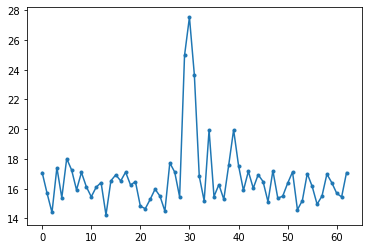

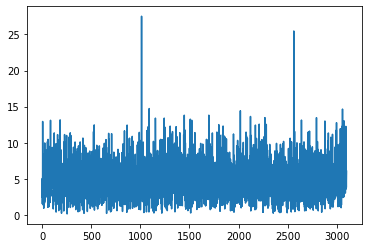

In [7]:
f_syms = np.fft.fft(syms[:f_sync_c.size])
corr = np.fft.ifft(f_syms * f_sync_c_shifts)
corr_vs_shift = np.max(np.abs(corr), axis=1)
plt.plot(corr_vs_shift, '.-')
max_shift = np.argmax(corr_vs_shift)
plt.figure()
plt.plot(np.abs(corr[max_shift]))
corr_pos = np.argmax(np.abs(corr[max_shift]))
freq_estimate = 2*np.pi/f_sync_c.size*doppler_shifts[max_shift]
phase_estimate = np.angle(corr[max_shift, corr_pos])
print(freq_estimate, phase_estimate, corr_pos)

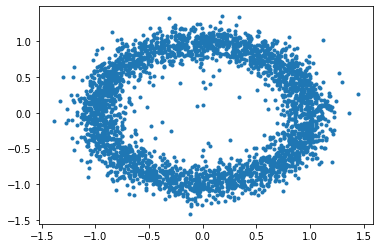

In [8]:
pilots = syms[corr_pos::apsk_mux]
prbs_wipe = np.tile(2*prbs-1, int(np.ceil(pilots.size/prbs.size)))
pilots = pilots * prbs_wipe[:pilots.size]
plt.plot(pilots.real, pilots.imag, '.')

In [9]:
class PLL:
    def __init__(self, prbs, apsk_mux, phase = 0, freq = 0,
                 debug = False):
        self.prbs = 2*prbs-1
        self.apsk_mux = apsk_mux
        self.current_sym = 0
        self.current_pilot = 0
        self.freq = freq
        self.phase = phase
        self.alpha = 0.1
        self.beta = 0.001
        self.amplitude_alpha = 0.1
        self.amplitude = 1.0
        self.debug = debug
        if self.debug:
            self.phases = list()
            self.freqs = list()
            self.amplitudes = list()
    
    def run_sample(self, x):
        if self.debug:
            self.phases.append(self.phase)
            self.freqs.append(self.freq)
            self.amplitudes.append(self.amplitude)
        x = self.amplitude * np.exp(-1j*self.phase) * x
        if self.current_sym == 0:
            # Pilot symbol
            x_wipe = x * self.prbs[self.current_pilot]
            phase_err = np.angle(x_wipe)
            self.freq += self.beta * phase_err
            self.phase += self.alpha * phase_err
            amplitude_error = 1.0 - x_wipe.real
            self.amplitude += self.amplitude_alpha * amplitude_error
            self.current_pilot += 1
            self.current_pilot %= self.prbs.size
        self.current_sym += 1
        self.current_sym %= self.apsk_mux
        self.phase += self.freq
        self.phase = (self.phase + np.pi) % (2*np.pi) - np.pi
        return x
    
    def run(self, syms):
        return np.array([self.run_sample(x) for x in syms])

In [10]:
pll = PLL(prbs, apsk_mux, freq = freq_estimate, phase = phase_estimate,
          debug = True)
syms_out = pll.run(syms[corr_pos:])

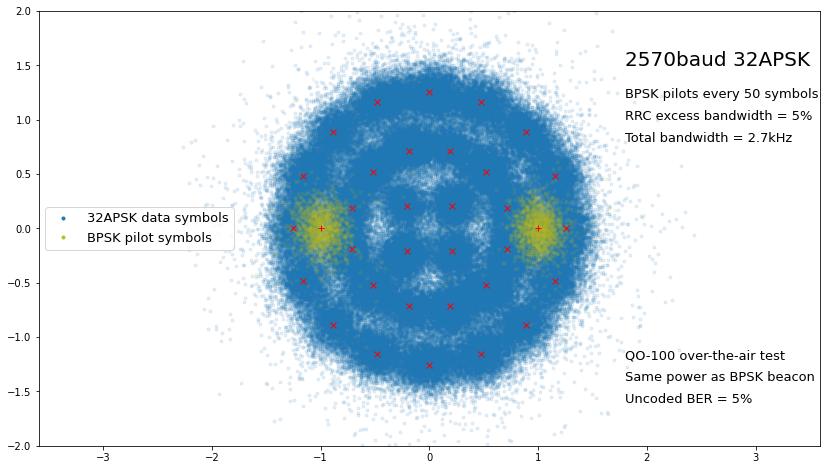

In [11]:
plt.figure(figsize = (14,8), facecolor='w')
sel_pilots = np.arange(syms_out.size) % apsk_mux == 0
plt.plot(syms_out[~sel_pilots].real, syms_out[~sel_pilots].imag, '.', alpha=0.1)
plt.plot(syms_out[sel_pilots].real, syms_out[sel_pilots].imag, '.', color='C8', alpha=0.1)
plt.plot(apsk32_constellation.real, apsk32_constellation.imag, 'x', color='red')
plt.plot([-1,1], [0,0], '+', color='red')
plt.axis('equal')
plt.ylim((-2, 2))
plt.text(1.8, 1.5, '2570baud 32APSK', size=20)
plt.text(1.8, 1.2, 'BPSK pilots every 50 symbols', size=13)
plt.text(1.8, 1.0, 'RRC excess bandwidth = 5%', size=13)
plt.text(1.8, 0.8, 'Total bandwidth = 2.7kHz', size=13)
plt.text(1.8, -1.2, 'QO-100 over-the-air test', size=13)
plt.text(1.8, -1.4, 'Same power as BPSK beacon', size=13)
plt.text(1.8, -1.6, 'Uncoded BER = 5%', size=13)
leg = plt.legend(['32APSK data symbols', 'BPSK pilot symbols'],
                 loc='center left', prop={'size': 13})
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)

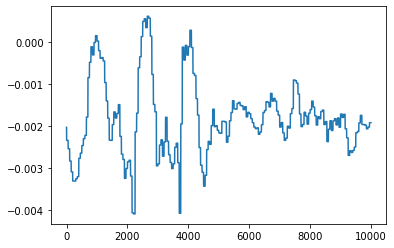

In [12]:
plt.plot(pll.freqs[:10000])

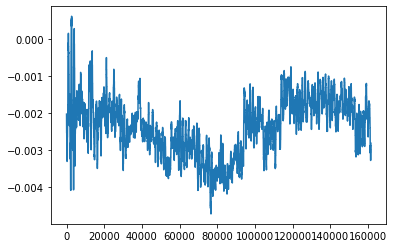

In [13]:
plt.plot(pll.freqs)

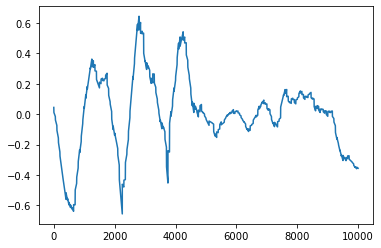

In [14]:
plt.plot(scipy.signal.detrend(np.unwrap(pll.phases[:10000])))

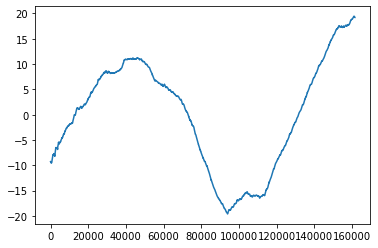

In [15]:
plt.plot(scipy.signal.detrend(np.unwrap(pll.phases)))

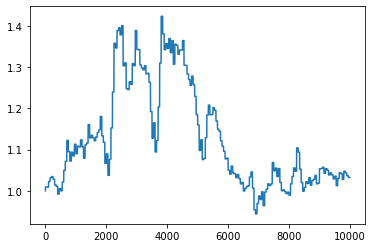

In [16]:
plt.plot(pll.amplitudes[:10000])

In [17]:
symbol_dist = np.abs(syms_out[~sel_pilots][:,np.newaxis] - apsk32_constellation[np.newaxis, :])
decode = np.array(apsk32_symbol_map)[np.argmin(symbol_dist, axis = 1)].astype('uint8')
decode_bits = np.unpackbits(decode[:,np.newaxis], axis=1)[:,-5:].ravel()

transmit = np.fromfile('apsk32_data.u8', 'uint8')
transmit_bits = np.unpackbits(transmit[:,np.newaxis], axis=1)[:,-5:].ravel()

transmit_bits_tile = np.tile(transmit_bits, int(np.ceil(decode_bits.size/transmit_bits.size)))
ber = np.average((decode_bits ^ transmit_bits_tile[:decode_bits.size]).astype('int'))
ber

0.049884666670879756